In [ ]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add the parent directory to the system path
sys.path.append(parent_dir)

# Flipping probelm of `geemap.download_ee_image()` function

In [1]:
import ee
import geemap
from skimage import io
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
ee.Initialize()
Map = geemap.Map()

In [3]:
aguasclaras_adj_goiania = ee.Geometry.Polygon(
[[[-49.359512, -16.762817], [-49.359512, -16.627659], [-49.198151, -16.627659], [-49.198151, -16.762817], [-49.359512, -16.762817]]], None, False
)

roi = aguasclaras_adj_goiania

### Functions

In [4]:
def top_left_roi(roi: ee.Geometry) -> ee.Geometry:
    """
    Divides a square region of interest (ROI) into four pieces and returns the coordinates
    of the top-left rectangular piece as an ee.Geometry object.
    
    Args:
        roi: An ee.Geometry object representing a square region of interest.
        
    Returns:
        An ee.Geometry object representing the top-left piece of the ROI.
        
        this output can be used as the input of `add_driection_band` function
    """
    square_coords = roi.bounds().getInfo()['coordinates'][0] # getting the list of coorinates
    # Removing the duplicate vlues form the list so we only have 4 coordiantes of the rectangle 
    square_coords = list(set(tuple(x) for x in square_coords))
    square_coords = [list(x) for x in square_coords]
    
    # Find x-coordinates of left and right edges of the square
    x_left = min(coord[0] for coord in square_coords)
    x_right = max(coord[0] for coord in square_coords)

    # Find y-coordinates of top and bottom edges of the square
    y_top = max(coord[1] for coord in square_coords)
    y_bottom = min(coord[1] for coord in square_coords)

    # Calculate center x-coordinate and center y-coordinate
    x_center = (x_left + x_right) / 2
    y_center = (y_top + y_bottom) / 2

    # Create coordinates for each quarter of the square
    top_left = (x_left, y_top)
    top_right = (x_center, y_top)
    bottom_left = (x_left, y_center)
    bottom_right = (x_center, y_center)

    # Return coordinates of the top-left quarter
    top_left_square = [top_left, top_right, bottom_right, bottom_left] # List of tupples
     
    # Converting the coordinate list to ee.Geometry
    top_left_square = ee.Geometry.Polygon(top_left_square)
    return top_left_square


def add_driection_band(image: ee.Image, roi: ee.Geometry) -> ee.Image:
    """
    Adds a constant band with value 1 in the top left corner quartre of the given ROI to the input image.
    
    
    This is due to the bug in geemap.ee_image_download, wheer downlaods some of the images vertically flipped.
    ths extra band can be used to figure the right direction of the image.

    Args:
        image (ee.Image): The input image to add the constant band to.
        roi (ee.Geometry): The ROI to clip the output image to. must be rectangular.
        
    Attributes:
        `top_left_square_roi`: The top left quarter of the ROI, created using the `top_left_roi` function.

    Returns:
        ee.Image: The input image with the constant band added.
    """
    # Create a constant band of zeros
    constant_band = ee.Image.constant(0)
    # Set the pixel value at the top left corner to 1
    top_left_square_roi = top_left_roi(roi)
    
    constant_band_with_one = constant_band.paint(top_left_square_roi, 1).clip(roi)
    # Add the constant band with one to the image
    image_with_constant_band = image.addBands(constant_band_with_one.clip(roi))
    return image_with_constant_band.clip(roi)

def plot_bands(image):
    """
    Plots each band of an image represented as a numpy array
    """
    num_bands = image.shape[-1]
    fig, axs = plt.subplots(1, num_bands, figsize=(5*num_bands, 5))
    
    for i in range(num_bands):
        axs[i].imshow(image[:,:,i]) if i==num_bands-1 else axs[i].imshow(image[:,:,i], cmap='gray') 
        axs[i].set_title(f'Band {i+1}')
        axs[i].axis('off')
    
    plt.show()
    
    
def reshape_array(array: np.ndarray, channel_first=True) -> np.ndarray:
    """Takes in an array and reshapes it to (C,H,W) or (H,W,C) based on user input.
    
    Args
    ----
    `array`: a numpy array of shape (H,W,C) or (C,H,W) or (H,W)
    `channel_first`: if True, the output array will be of shape (C,H,W) otherwise it will be (H,W,C)
    
    This Algorithm won't work if C is larger than H or W
    We assume that the smallest dimension is the channel dimension.
    """
    if channel_first:
        if array.ndim == 2: # If it is a 2D image we need to add a channel dimension
            array = np.expand_dims(array, axis=0)
        elif array.ndim == 3 and array.shape[2] < array.shape[0]: # if it is a 3D image and 3rd dim is smallest, it means it it the channel so we permute
            array = np.swapaxes(array, 0, 2)
            array = np.swapaxes(array, 1, 2)
        elif array.ndim == 3 and array.shape[2] > array.shape[0]: # if it is a 3D image and and the first dimension is smaller than others it means its the C and we don't need to permute.
            pass
        else:
            raise ValueError(f"Input array shape is invalid: {array.shape}")
    
    else:
        if array.ndim == 2:
            array = np.expand_dims(array, axis=-1)
        elif array.ndim == 3 and array.shape[0] < array.shape[2]:
            array = np.swapaxes(array, 0, 2)
            array = np.swapaxes(array, 0, 1)
        elif array.ndim == 3 and array.shape[0] > array.shape[2]:
            pass
        else:
            raise ValueError(f"Input array shape is invalid: {array.shape}")
    
    return array


### Setting the Image

In [5]:
s1_col = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate('2021-06-15', '2021-09-15') \
    .filterBounds(roi) \
    .filter(ee.Filter.eq('resolution','H')) \
    .filter(ee.Filter.eq('instrumentMode','IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass','DESCENDING'))\
    
image = s1_col.mean().clip(roi)

### Direction Band
`add_direction` function adds an extra band to the image, where the top left corner quarter of the image is `1` and others are `0`. This can help us to identify the direction of the downlaoaded image and what kinda flip happend to it.

In [6]:
image_with_dricetion_band = add_driection_band(image,roi)
image_with_dricetion_band.bandNames().getInfo()

['VV', 'VH', 'angle', 'constant']

In [7]:
constant_vis_params = {
    'min': 0,
    'max': 1,
    'bands': ['constant']
}

Map = geemap.Map()
Map.addLayer(image_with_dricetion_band, constant_vis_params, 'Image with constant band')
Map.centerObject(roi, zoom=10)
Map

Map(center=[-16.6952352441233, -49.278831500000265], controls=(WidgetControl(options=['position', 'transparent…

### Download using `download_ee_image` function

In [8]:
import rasterio as rio

In [17]:
img_w_dir = image_with_dricetion_band.select('VV','constant')
#EPSG:4326 or EPSG:3857
img_w_dir = img_w_dir.reproject(crs='EPSG:3857', scale=10)
print(img_w_dir.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:3857', 'transform': [10, 0, 0, 0, -10, 0]}


In [19]:
geemap.download_ee_image(img_w_dir, "image_with_direciton_download.tif",crs='EPSG:4326',scale=10,region = roi)

image_with_direciton_download.tif: |          | 0.00/43.3M (raw) [  0.0%] in 00:00 (eta:     ?)

### Downloading the image using `ee_export_image` function

In [99]:
geemap.ee_export_image(img_w_dir, "image_with_direciton_export.tif", crs='EPSG:4326', scale=10, region=roi)

Generating URL ...
Please wait ...
Data downloaded to d:\python\TemporalGAN\dataset\image_with_direciton_export.tif


## Results
As we can see the imgage downlaoded with `download_ee_image` function is flipped. The image downloaded with `ee_export_image` function is not flipped.

(2, 1505, 1797)
25.476370619545364


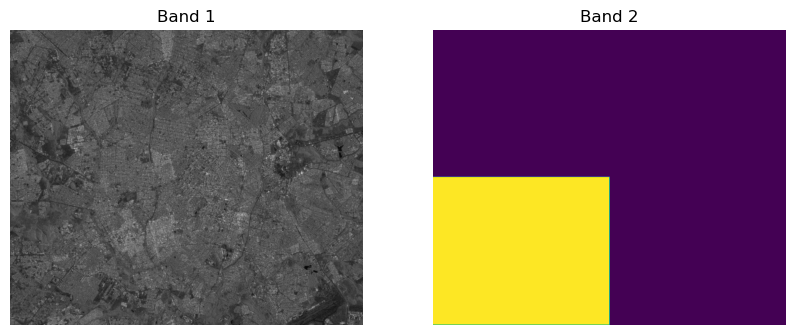

In [22]:
img = io.imread("image_with_direciton_download.tif")
print(img.shape)
img = reshape_array(img, channel_first = False)
print(np.max(img[:,:,0]))
plot_bands(img)

(1505, 1797, 2)
(1505, 1797, 2)


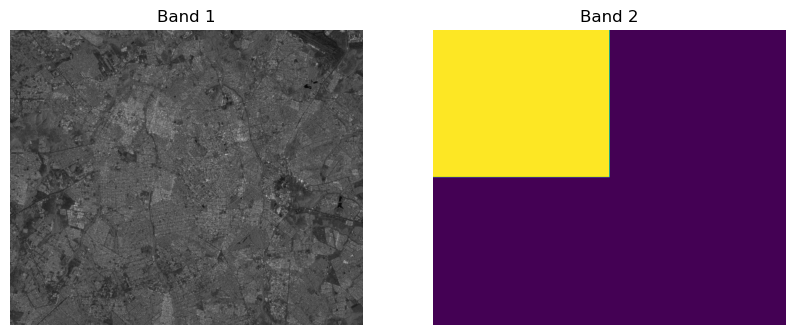

In [101]:
img = io.imread("image_with_direciton_export.tif")
print(img.shape)
img = reshape_array(img, channel_first = False)
print(img.shape)
plot_bands(img)

### The prblem goes away when we use a `projection`  `EPSG:4326`

In [57]:
img_w_dir = image_with_dricetion_band.select('VV','constant')
#EPSG:4326 or EPSG:3857
geemap.download_ee_image(img_w_dir, "image_with_direciton_download_3857.tif",crs='EPSG:3857' ,scale=10,region = roi)

image_with_direciton_download_3857.tif: |          | 0.00/45.2M (raw) [  0.0%] in 00:00 (eta:     ?)

(2, 1572, 1797)
(1572, 1797, 2)


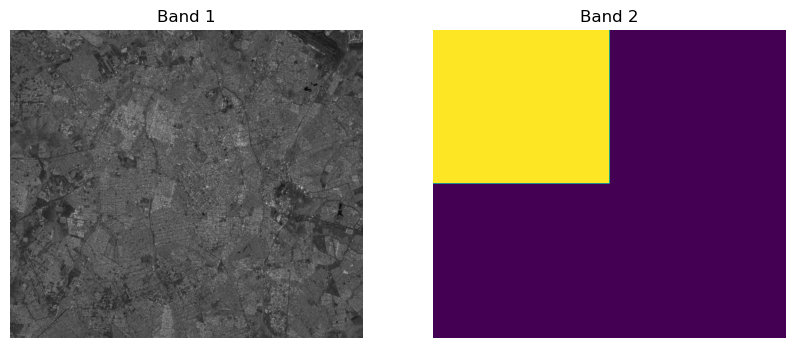

In [58]:
img = io.imread("image_with_direciton_download_3857.tif")
print(img.shape)
img = reshape_array(img, channel_first = False)
print(img.shape)
plot_bands(img)